In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0569-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0523-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1285-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1262-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1017-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0971-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0937-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0561-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0425-0001.jpeg
/kaggle

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0811-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0465-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0877-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0772-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1108-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0819-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0634-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1261-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1365-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0388-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/ch

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1415_virus_2425.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person162_virus_319.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person400_virus_794.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person490_virus_996.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1710_bacteria_4526.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person110_virus_206.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person277_bacteria_1304.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person417_bacteria_1841.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1217_virus_2063.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1548_virus_2689.jpeg
/

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1411_bacteria_3602.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1482_virus_2572.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person573_virus_1116.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1315_bacteria_3322.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1294_bacteria_3257.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person451_bacteria_1942.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person958_virus_1630.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person659_bacteria_2551.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1924_bacteria_4832.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person558_vir

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person145_virus_295.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person27_bacteria_135.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1494_bacteria_3901.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person374_bacteria_1712.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person880_virus_1529.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person419_virus_855.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1535_virus_2672.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1188_virus_2024.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1315_virus_2270.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1406_bacteria_3574.jp

/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0249-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0298-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0730-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0971-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0533-0001-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1043-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0216-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0274-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1128-0001-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/trai

/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person633_virus_1213.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person868_virus_1513.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person37_bacteria_188.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person810_bacteria_2719.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1670_bacteria_4428.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1294_virus_2222.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person71_bacteria_350.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person255_bacteria_1175.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1222_virus_2071.j

/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1100_virus_1820.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person949_virus_1620.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person30_bacteria_151.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person119_virus_225.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person26_bacteria_131.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1482_virus_2569.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person255_bacteria_1162.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person281_bacteria_1326.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1344_virus_2320.jpeg


/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person59_virus_116.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person96_bacteria_464.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person111_bacteria_536.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person80_bacteria_392.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person1_virus_8.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person60_virus_117.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person80_bacteria_389.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person8_virus_28.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person39_virus_85.jpeg
/kaggle/input/chest-xray-pneum

/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0569-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0523-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1285-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1262-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1017-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0971-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0937-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0561-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0425-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0372-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0526-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1126-0001.jpeg
/kaggle

/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1415_virus_2425.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person162_virus_319.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person400_virus_794.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person490_virus_996.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1710_bacteria_4526.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person110_virus_206.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person277_bacteria_1304.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person417_bacteria_1841.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1217_virus_2063.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1548_virus_2689.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1281_virus_2204.jpeg
/kaggle/input/chest-xr

/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person427_bacteria_1865.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person836_bacteria_2752.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person38_bacteria_194.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person298_bacteria_1412.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person23_bacteria_79.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person627_virus_1204.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person833_virus_1469.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1156_virus_1936.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1002_bacteria_2933.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person716_bacteria_2617.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg
/kaggle/inp

/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0376-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0351-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0232-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0359-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0145-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0058-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0252-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0310-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0039-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0332-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0132-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0297-0001.jpeg


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dense, Flatten,BatchNormalization,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report,log_loss
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import glob
import random
import os
import seaborn as sns

In [4]:
train_path = r'../input/chest-xray-pneumonia/chest_xray/train'
test_path = r'../input/chest-xray-pneumonia/chest_xray/test'
val_path = r'../input/chest-xray-pneumonia/chest_xray/val'

datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
height_shift_range=0.1,shear_range=0.15, 
zoom_range=0.1,channel_shift_range = 10, horizontal_flip=True)

image_path = r'../input/chest-xray-pneumonia/chest_xray/train/NORMAL'
save_path = r'./'
for i in os.listdir(image_path):
    image = load_img(os.path.join(image_path,i))
    image = np.expand_dims(image,axis=0)
    datagen.fit(image)

    for x, val in zip(datagen.flow(image,                    #image we chose
        save_to_dir=save_path,     #this is where we figure out where to save
         save_prefix='aug',        # it will save the images as 'aug_0912' some number for every new augmented image
        save_format='jpeg'),range(1)) :     # here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
        pass

In [5]:
image_size=[224,224]

datagen = ImageDataGenerator(rescale = 1/255, samplewise_std_normalization = True,
                            samplewise_center = True)

train_batch = datagen.flow_from_directory(directory=train_path
                                          ,batch_size = 250,target_size=image_size,shuffle =True, seed=0,
                                          classes=['NORMAL','PNEUMONIA'])

test_batch = datagen.flow_from_directory(directory=test_path
                                          ,batch_size =16,target_size=image_size,shuffle =False
                                          ,classes=['NORMAL','PNEUMONIA'])

val_batch = datagen.flow_from_directory(directory=val_path
                                          ,batch_size = 624,target_size=image_size,shuffle =True
                                          ,classes=['NORMAL','PNEUMONIA'])
train_batch.class_indices

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


{'NORMAL': 0, 'PNEUMONIA': 1}

,Status,Img_name
0,NORMAL,NORMAL2-IM-0569-0001.jpeg
1,NORMAL,NORMAL2-IM-0523-0001.jpeg
2,NORMAL,NORMAL2-IM-1285-0001.jpeg
3,NORMAL,NORMAL2-IM-1262-0001.jpeg
4,NORMAL,NORMAL2-IM-1017-0001.jpeg
...,...,...
5211,PNEUMONIA,person675_bacteria_2569.jpeg
5212,PNEUMONIA,person509_virus_1025.jpeg
5213,PNEUMONIA,person162_virus_320.jpeg
5214,PNEUMONIA,person1637_bacteria_4339.jpeg


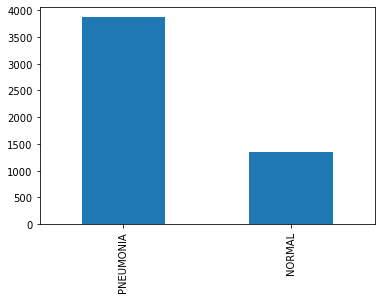

In [6]:
nor_path = r'../input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
pneu_path = r'../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'

label = ['NORMAL','PNEUMONIA']

files = [[j,k] for j in label for k in 
         os.listdir(os.path.join(r'../input/chest-xray-pneumonia/chest_xray/train',j))]
df = pd.DataFrame(files,columns=['Status','Img_name'])

df.Status.value_counts().plot(kind='bar')
df

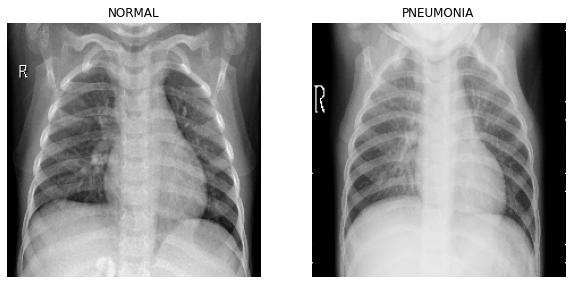

In [7]:


nor_img = load_img(os.path.join(nor_path, df[df.Status == 'NORMAL'].Img_name[0])
                   ,target_size=(224,224))
pne_img = load_img(os.path.join(pneu_path, df[df.Status == 'PNEUMONIA'].Img_name.iloc[2]),
                   target_size=(224,224))

def img_(nor_img,pne_img):
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.title('NORMAL')
    plt.imshow(nor_img)
    plt.axis('off')

    plt.subplot(122)
    plt.title('PNEUMONIA')
    plt.imshow(pne_img)
    plt.axis('off')
img_(nor_img,pne_img)

In [8]:
def result_plot(train_accuracy, val_accuracy,train_loss,val_loss):
    plt.figure(figsize=(15,5))
    
    plt.subplot(121)
    plt.plot(train_accuracy) , plt.plot(val_accuracy)
    plt.xticks(np.arange(1,len(train_accuracy)+1),np.arange(1,len(train_accuracy)+1))
    plt.xlabel('No.of Epoch'),plt.ylabel('Accuracy'),plt.legend(['train_accuracy','val_accuracy'],
                                                          bbox_to_anchor=(.575,.575,.575,.575))
    plt.ylim(0,1.2)
    
    plt.subplot(122)
    plt.plot(train_loss) , plt.plot(val_loss)
    plt.xticks(np.arange(1,len(train_accuracy)+1),np.arange(1,len(train_accuracy)+1))
    plt.xlabel('No. of Epoch'),plt.ylabel('loss'),plt.legend(['train_loss','val_loss'],
                                                          bbox_to_anchor=(.575,.575,.575,.575))
    plt.ylim(0,max(max(val_loss),max(train_loss)))
    

In [9]:
model = Sequential([Conv2D(filters = 16 ,kernel_size = (3,3), activation='relu', padding = 'valid',
                          input_shape = (224,224,3)),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                   Conv2D(filters = 32 ,kernel_size = (3,3), activation='relu', padding = 'valid'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    Conv2D(filters = 64 ,kernel_size = (3,3), activation='relu', padding = 'valid'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    Conv2D(filters = 128 ,kernel_size = (3,3), activation='relu', padding = 'valid'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    BatchNormalization(),
                    Conv2D(filters = 128 ,kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    #BatchNormalization(),
                    #Conv2D(filters = 500 ,kernel_size = (3,3), activation='relu', padding = 'same'),
                   #MaxPool2D(pool_size = (2,2), strides = 2),
                    Flatten(),
                    Dropout(0.5),
                    Dense(units = 512,activation = 'relu'),
                    Dense(units = 2,activation = 'softmax')])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', patience=5, 
        verbose=1, mode='min', restore_best_weights=True)


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

In [11]:
r = model.fit_generator(train_batch,
  validation_data=val_batch,
  epochs=100,
  steps_per_epoch=len(train_batch),
  validation_steps=len(test_batch),
  callbacks=[monitor] )

Epoch 1/100
21/21 [==============================] - 70s 3s/step - loss: 1.0068 - accuracy: 0.8144 - val_loss: 0.6879 - val_accuracy: 0.5000
Epoch 2/100
21/21 [==============================] - 54s 3s/step - loss: 0.1453 - accuracy: 0.9450 - val_loss: 0.6655 - val_accuracy: 0.5625
Epoch 3/100
21/21 [==============================] - 54s 3s/step - loss: 0.0923 - accuracy: 0.9647 - val_loss: 0.6677 - val_accuracy: 0.5000
Epoch 4/100
21/21 [==============================] - 55s 3s/step - loss: 0.0731 - accuracy: 0.9732 - val_loss: 0.6631 - val_accuracy: 0.5000
Epoch 5/100
21/21 [==============================] - 55s 3s/step - loss: 0.0657 - accuracy: 0.9753 - val_loss: 0.6093 - val_accuracy: 0.9375
Epoch 6/100
21/21 [==============================] - 54s 3s/step - loss: 0.0624 - accuracy: 0.9772 - val_loss: 0.5724 - val_accuracy: 0.6250
Epoch 7/100
21/21 [==============================] - 54s 3s/step - loss: 0.0472 - accuracy: 0.9806 - val_loss: 0.5525 - val_accuracy: 0.9375
Epoch 8/100
2

In [12]:
pred = model.predict(test_batch)
pred_class = model.predict_classes(test_batch)

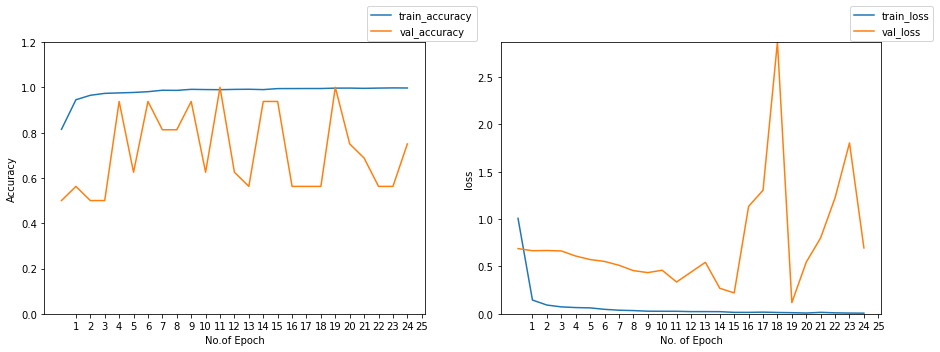

In [13]:
train_loss = r.history['loss']
val_loss = r.history['val_loss']
train_accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

              precision    recall  f1-score   support

           0       0.94      0.47      0.63       234
           1       0.76      0.98      0.85       390

    accuracy                           0.79       624
   macro avg       0.85      0.73      0.74       624
weighted avg       0.82      0.79      0.77       624



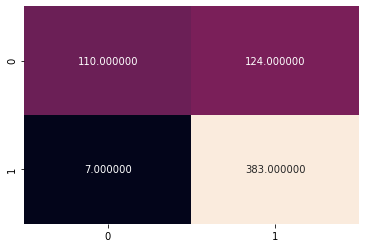

In [14]:
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),cbar = False,annot =True,fmt = 'f')
print(classification_report(test_batch.classes,pred_class))


0.726068376068376


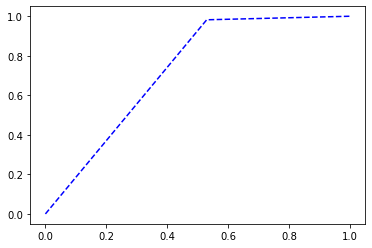

In [15]:
from sklearn.metrics import roc_auc_score,roc_curve

fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score = roc_auc_score(test_batch.labels,pred_class)
print(auc_score)

plt.plot(fpr,tpr , "b--")

In [16]:
vgg16 = tf.keras.applications.vgg16.VGG16(input_shape = image_size+[3]
                                                ,weights='imagenet'
                                                ,include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [17]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
model_vgg = Sequential()

for layer in vgg16.layers:
    layer.trainable =False
    model_vgg.add(layer)
    
model_vgg.add(Flatten())
model_vgg.add(Dense(units = 2,activation = 'softmax'))
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [19]:
model_vgg.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy'
              , metrics=['accuracy'])

r_vgg = model_vgg.fit(train_batch,
  validation_data=val_batch,
  epochs=100,
  steps_per_epoch=len(train_batch),
  validation_steps=len(val_batch),
            callbacks=[monitor] )

Epoch 1/100
21/21 [==============================] - 56s 3s/step - loss: 0.5797 - accuracy: 0.8230 - val_loss: 0.1660 - val_accuracy: 0.9375
Epoch 2/100
21/21 [==============================] - 56s 3s/step - loss: 0.1086 - accuracy: 0.9588 - val_loss: 0.1233 - val_accuracy: 0.9375
Epoch 3/100
21/21 [==============================] - 57s 3s/step - loss: 0.0608 - accuracy: 0.9760 - val_loss: 0.0947 - val_accuracy: 0.9375
Epoch 4/100
21/21 [==============================] - 57s 3s/step - loss: 0.0455 - accuracy: 0.9850 - val_loss: 0.0906 - val_accuracy: 1.0000
Epoch 5/100
21/21 [==============================] - 57s 3s/step - loss: 0.0356 - accuracy: 0.9904 - val_loss: 0.0777 - val_accuracy: 1.0000
Epoch 6/100
21/21 [==============================] - 57s 3s/step - loss: 0.0299 - accuracy: 0.9923 - val_loss: 0.0698 - val_accuracy: 1.0000
Epoch 7/100
21/21 [==============================] - 57s 3s/step - loss: 0.0247 - accuracy: 0.9952 - val_loss: 0.0683 - val_accuracy: 1.0000
Epoch 8/100
2

In [20]:
pred = model_vgg.predict(test_batch)
pred_class = model_vgg.predict_classes(test_batch)

In [ ]:
train_loss = r_vgg.history['loss']
val_loss = r_vgg.history['val_loss']
train_accuracy = r_vgg.history['accuracy']
val_accuracy = r_vgg.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

AUC Score: 0.735897435897436
              precision    recall  f1-score   support

           0       0.99      0.47      0.64       234
           1       0.76      1.00      0.86       390

    accuracy                           0.80       624
   macro avg       0.88      0.74      0.75       624
weighted avg       0.85      0.80      0.78       624



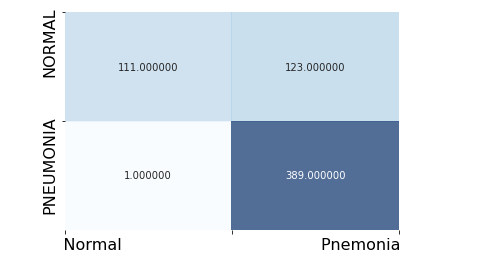

In [21]:
from sklearn.metrics import roc_auc_score,roc_curve

fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score = roc_auc_score(test_batch.labels,pred_class)
print("AUC Score:",auc_score)


plt.figure()
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(range(2),label,fontsize= 16)
print(classification_report(test_batch.classes,pred_class))


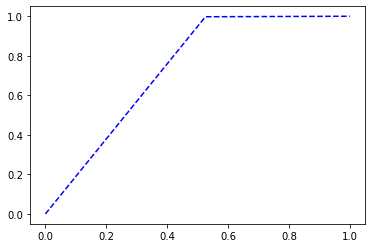

In [22]:
plt.plot(fpr,tpr , "b--")

In [23]:
resnet = tf.keras.applications.ResNet50(input_shape = image_size+[3],
                                        weights='imagenet',
                                        include_top=False)
resnet.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [24]:

for layer in resnet.layers:
    layer.trainable = False
x = Flatten()(resnet.output)
output = Dense(units = 2 , activation ='softmax')(x)
model_res = Model(inputs=resnet.input , outputs= output)

model_res.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [25]:
model_res.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy'
              , metrics=['accuracy'])

In [26]:
r = model_res.fit(train_batch,
  validation_data=val_batch,
  epochs=20,
  steps_per_epoch=len(train_batch),
  validation_steps=len(val_batch))#,callbacks=[monitor]

Epoch 1/20
21/21 [==============================] - 56s 3s/step - loss: 3.3098 - accuracy: 0.7502 - val_loss: 4.5928 - val_accuracy: 0.6250
Epoch 2/20
21/21 [==============================] - 55s 3s/step - loss: 0.6138 - accuracy: 0.9181 - val_loss: 0.6292 - val_accuracy: 0.8125
Epoch 3/20
21/21 [==============================] - 56s 3s/step - loss: 0.2269 - accuracy: 0.9553 - val_loss: 1.1985 - val_accuracy: 0.7500
Epoch 4/20
21/21 [==============================] - 56s 3s/step - loss: 0.1129 - accuracy: 0.9714 - val_loss: 0.7492 - val_accuracy: 0.6875
Epoch 5/20
21/21 [==============================] - 56s 3s/step - loss: 0.0737 - accuracy: 0.9783 - val_loss: 0.3201 - val_accuracy: 0.9375
Epoch 6/20
21/21 [==============================] - 55s 3s/step - loss: 0.0485 - accuracy: 0.9826 - val_loss: 0.3320 - val_accuracy: 0.9375
Epoch 7/20
21/21 [==============================] - 55s 3s/step - loss: 0.0363 - accuracy: 0.9877 - val_loss: 0.4862 - val_accuracy: 0.8125
Epoch 8/20
21/21 [==

In [27]:
pred = model_res.predict(test_batch)
pred_class = pred.argmax(axis=-1)

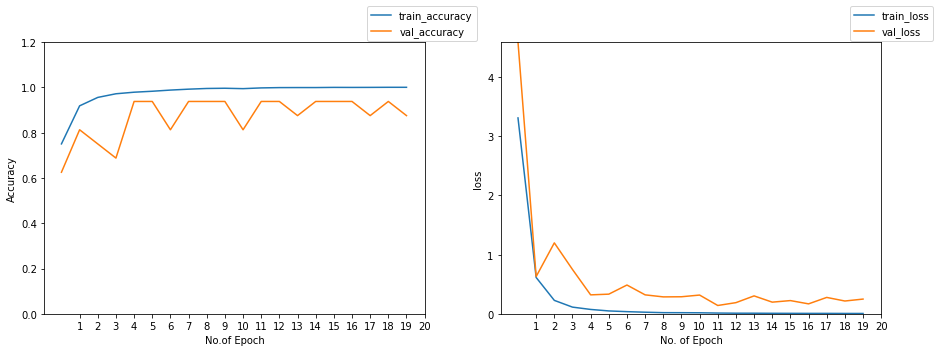

In [34]:
train_loss = r.history['loss']
val_loss = r.history['val_loss']
train_accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

AUC Score: 0.6598290598290598
              precision    recall  f1-score   support

           0       0.97      0.32      0.49       234
           1       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624



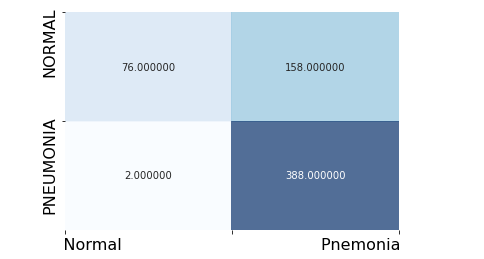

In [28]:
from sklearn.metrics import roc_auc_score,roc_curve

fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score = roc_auc_score(test_batch.labels,pred_class)
print("AUC Score:",auc_score)


plt.figure()
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(range(2),label,fontsize= 16)
print(classification_report(test_batch.classes,pred_class))


In [1]:
mobilnet_model =  tf.keras.applications.MobileNetV2(input_shape = image_size+[3]
                                                    ,weights='imagenet'
                                                    ,include_top=False)

NameError: name 'tf' is not defined

In [ ]:
for layer in mobilnet_model.layers:
    layer.trainable = False
x = Flatten()(mobilnet_model.output)
x_1 = Dropout(0.5)(x)
output = Dense(units = 2 , activation ='softmax')(x_1)
model_mobilnet = Model(inputs=mobilnet_model.input , outputs= output)

model_mobilnet.summary()

In [ ]:
model_mobilnet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy'
              , metrics=['accuracy'])
r = model_mobilnet.fit(train_batch,
  validation_data=val_batch,
  epochs=100,
  steps_per_epoch=len(train_batch),
  validation_steps=len(val_batch),callbacks=[monitor])

In [ ]:
train_loss = r.history['loss']
val_loss = r.history['val_loss']
train_accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

In [32]:
pred = model_mobilnet.predict(test_batch)
pred_class = pred.argmax(axis=-1)

AUC Score: 0.7461538461538462
              precision    recall  f1-score   support

           0       0.97      0.50      0.66       234
           1       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.76       624
weighted avg       0.85      0.81      0.79       624



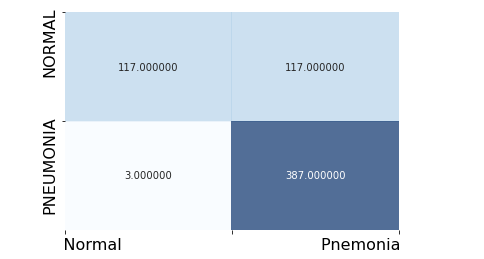

In [33]:
fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score = roc_auc_score(test_batch.labels,pred_class)
print("AUC Score:",auc_score)


plt.figure()
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),alpha = 0.7
            ,cbar = False,annot =True,fmt = 'f',cmap=plt.cm.Blues)
plt.xticks(np.arange(3),['           Normal',"",'Pnemonia               ' ],
           fontsize=16,rotation=0)
plt.yticks(range(2),label,fontsize= 16)
print(classification_report(test_batch.classes,pred_class))